## ECG Arrhythmia Classification – Project Demonstration

This notebook demonstrates our ECG arrhythmia classification project using the MIT-BIH Arrhythmia Database.

- **Goal**: Classify individual ECG beats into clinically meaningful arrhythmia categories.
- **Models**: A baseline 1D CNN and an LSTM autoencoder classifier.
- **Data**: Preprocessed per-beat windows centered on R-peaks from MIT-BIH records.

We will:
- Load **pre-trained checkpoints** for several CNN and LSTM configurations from `src/checkpoints/`.
- Show **full test-set metrics** that were saved during training.
- Run **fast live inference** on a small subset of the test data (well under 1 minute) to illustrate predictions and reconstructions.
- Visualize example ECG beats with model predictions.


In [33]:
# Imports and basic configuration

import os
import sys
import json
import time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Ensure src/ is on the Python path so we can import project modules
project_root = Path('.').resolve()
src_dir = project_root / 'src'
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

from dataset import BeatDataset, CLASS_NAMES, create_patient_splits
from models_simple_cnn import SimpleBeatCNN
from models_lstm_autoencoder import LSTMAutoencoderClassifier

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Number of classes: {len(CLASS_NAMES)} → {CLASS_NAMES}")


Using device: cuda
Number of classes: 6 → ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Paced', 'Unknown']


In [34]:
# Helper functions for loading configs, models, data, and evaluating quickly

from typing import Dict, Any, Tuple


def get_seq_len(window_size: float, fs: int = 360) -> int:
    """Convert window size in seconds to number of samples."""
    return int(round(window_size * fs))


def load_config(checkpoint_dir: Path) -> Dict[str, Any]:
    """Load training config saved with a checkpoint."""
    cfg_path = checkpoint_dir / 'config.json'
    with cfg_path.open('r', encoding='utf-8') as f:
        return json.load(f)


def build_model_from_config(config: Dict[str, Any]) -> nn.Module:
    """Instantiate the correct model architecture from a config dict."""
    num_classes = config.get('num_classes', len(CLASS_NAMES))
    model_name = config['model']
    window_size = config.get('window_size', 0.8)
    seq_len = get_seq_len(window_size)

    if model_name == 'simple_cnn':
        model = SimpleBeatCNN(num_classes=num_classes)
    elif model_name == 'lstm_autoencoder':
        model = LSTMAutoencoderClassifier(seq_len=seq_len, num_classes=num_classes)
    else:
        raise ValueError(f"Unsupported model in config: {model_name}")

    return model.to(device)


def load_best_model(checkpoint_dir: Path, config: Dict[str, Any]) -> nn.Module:
    """Load the best checkpoint weights for a run.

    Note: In PyTorch ≥ 2.6, `torch.load` defaults to `weights_only=True`, which
    can break loading older checkpoint dicts that include non-tensor objects.
    Here we explicitly set `weights_only=False` for backward compatibility.
    """
    model = build_model_from_config(config)
    ckpt_path = checkpoint_dir / 'best_model.pth'
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model


def create_test_loader_from_config(
    config: Dict[str, Any],
    batch_size: int = 128,
    num_workers: int = 0,
) -> Tuple[DataLoader, BeatDataset]:
    """Create a test DataLoader that matches the original training split.

    We rely on the `test_records` list saved in the config, so we evaluate
    on the exact same test patients/beats used during training.
    """
    # Default full MIT-BIH path in this project
    default_data_dir = (
        project_root
        / 'data'
        / 'mit-bih-arrhythmia-database-1.0.0'
        / 'mit-bih-arrhythmia-database-1.0.0'
    )

    data_dir = config.get('data_dir', str(default_data_dir))
    # If the stored path does not exist (e.g., older alias like ../data/mitdb),
    # fall back to the canonical MIT-BIH path.
    if not Path(data_dir).exists() and default_data_dir.exists():
        data_dir = str(default_data_dir)

    # Some older configs do not store explicit test_records; in that case we
    # reconstruct the splits using the original splitting logic to get a
    # deterministic test set matching training.
    test_records = config.get('test_records')
    beat_wise = config.get('beat_wise', False)
    split_mode = config.get('split_mode', '')

    train_ratio = config.get('train_ratio', 0.75)
    val_ratio = config.get('val_ratio', 0.125)
    test_ratio = config.get('test_ratio', 0.125)
    seed = config.get('seed', 42)
    stratified = config.get('stratified', False)

    if test_records is None:
        # Rebuild patient/beat-wise splits deterministically
        train_records, val_records, test_records = create_patient_splits(
            data_dir=data_dir,
            train_ratio=train_ratio,
            val_ratio=val_ratio,
            test_ratio=test_ratio,
            random_seed=seed,
            stratified=stratified,
            beat_wise=beat_wise,
        )

    # In this project, curated hybrid mode would use beat-wise train/val but
    # pure patient-wise test. For our runs here, split_mode is either
    # 'patient_wise', 'beat_wise', or 'curated_patient_wise'.
    is_hybrid = split_mode == 'curated_hybrid'
    test_beat_wise = False if is_hybrid else beat_wise

    window_size = config.get('window_size', 0.8)
    lead = config.get('lead', 0)
    train_ratio = config.get('train_ratio', 0.75)
    val_ratio = config.get('val_ratio', 0.125)
    seed = config.get('seed', 42)

    test_dataset = BeatDataset(
        test_records,
        data_dir=data_dir,
        window_size=window_size,
        lead=lead,
        beat_wise_split=test_beat_wise,
        split_name='test',
        train_ratio=train_ratio,
        val_ratio=val_ratio,
        random_seed=seed,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return test_loader, test_dataset


def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    is_autoencoder: bool = False,
    alpha: float = 1.0,
    beta: float = 1.0,
    max_batches: int = 10,
) -> Dict[str, Any]:
    """Quick evaluation on (up to) a small number of batches.

    This is designed to be **fast** for the demo notebook while still
    producing realistic predictions.
    """
    model.eval()
    ce_loss = nn.CrossEntropyLoss()

    total_loss = 0.0
    all_preds = []
    all_labels = []
    n_batches = 0

    start_time = time.time()
    with torch.no_grad():
        for batch_idx, (signals, labels) in enumerate(loader):
            if max_batches is not None and batch_idx >= max_batches:
                break

            signals = signals.to(device)
            labels = labels.to(device)

            if is_autoencoder:
                # LSTM autoencoder returns reconstruction + logits
                recon, logits = model(signals)
                recon_loss = model.reconstruction_loss(recon, signals)
                class_loss = model.classification_loss(logits, labels)
                loss = alpha * recon_loss + beta * class_loss
                outputs = logits
            else:
                outputs = model(signals)
                loss = ce_loss(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            n_batches += 1

    if n_batches == 0:
        raise RuntimeError("No batches were evaluated – check your DataLoader.")

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    avg_loss = total_loss / n_batches
    accuracy = 100.0 * (all_preds == all_labels).mean()
    elapsed = time.time() - start_time

    return {
        'avg_loss': float(avg_loss),
        'accuracy': float(accuracy),
        'n_samples': int(len(all_labels)),
        'elapsed_sec': float(elapsed),
        'y_true': all_labels,
        'y_pred': all_preds,
    }


In [35]:
# Define checkpoint locations for CNN and LSTM runs

CHECKPOINT_ROOT = project_root / 'src' / 'checkpoints'

cnn_runs = {
    'simple_cnn_baseline': CHECKPOINT_ROOT / 'simple_cnn_20251128_210025_baseline',
    'simple_cnn_beat_wise_stratified': CHECKPOINT_ROOT / 'simple_cnn_20251128_225939_beat_wise_stratified',
    'simple_cnn_optimal_patient_wise': CHECKPOINT_ROOT / 'simple_cnn_20251129_161558_optimal_patient_wise',
}

lstm_runs = {
    'lstm_patient_wise': CHECKPOINT_ROOT / 'lstm_autoencoder_20251129_195909_patient_wise',
    'lstm_beat_wise': CHECKPOINT_ROOT / 'lstm_autoencoder_20251129_201505_beat_wise',
    'lstm_curated_patient_wise': CHECKPOINT_ROOT / 'lstm_autoencoder_20251129_205008_curated_patient_wise',
}

print("Available CNN checkpoints:")
for name, path in cnn_runs.items():
    print(f"  {name}: {path}")

print("\nAvailable LSTM checkpoints:")
for name, path in lstm_runs.items():
    print(f"  {name}: {path}")


Available CNN checkpoints:
  simple_cnn_baseline: C:\Users\17320\Documents\Projects\Arrythmia_Classifier\src\checkpoints\simple_cnn_20251128_210025_baseline
  simple_cnn_beat_wise_stratified: C:\Users\17320\Documents\Projects\Arrythmia_Classifier\src\checkpoints\simple_cnn_20251128_225939_beat_wise_stratified
  simple_cnn_optimal_patient_wise: C:\Users\17320\Documents\Projects\Arrythmia_Classifier\src\checkpoints\simple_cnn_20251129_161558_optimal_patient_wise

Available LSTM checkpoints:
  lstm_patient_wise: C:\Users\17320\Documents\Projects\Arrythmia_Classifier\src\checkpoints\lstm_autoencoder_20251129_195909_patient_wise
  lstm_beat_wise: C:\Users\17320\Documents\Projects\Arrythmia_Classifier\src\checkpoints\lstm_autoencoder_20251129_201505_beat_wise
  lstm_curated_patient_wise: C:\Users\17320\Documents\Projects\Arrythmia_Classifier\src\checkpoints\lstm_autoencoder_20251129_205008_curated_patient_wise


In [36]:
# Load full test-set metrics saved during training for all runs

import pandas as pd


def load_summary(checkpoint_dir: Path) -> Dict[str, Any]:
    summary_path = checkpoint_dir / 'results_summary.json'
    if not summary_path.exists():
        return None
    with summary_path.open('r', encoding='utf-8') as f:
        return json.load(f)


rows = []
for family, runs in [('CNN', cnn_runs), ('LSTM', lstm_runs)]:
    for run_name, ckpt_dir in runs.items():
        summary = load_summary(ckpt_dir)
        if summary is None:
            print(f"WARNING: results_summary.json not found in {ckpt_dir}")
            continue
        test_info = summary['test']
        rows.append({
            'family': family,
            'run_name': run_name,
            'checkpoint_dir': str(ckpt_dir),
            'test_accuracy_full (%)': test_info['test_accuracy'],
            'test_loss_full': test_info['test_loss'],
        })

results_df = pd.DataFrame(rows).sort_values(['family', 'run_name']).reset_index(drop=True)
results_df


,family,run_name,checkpoint_dir,test_accuracy_full (%),test_loss_full
0,CNN,simple_cnn_baseline,C:\Users\17320\Documents\Projects\Arrythmia_Cl...,83.881789,0.826056
1,CNN,simple_cnn_beat_wise_stratified,C:\Users\17320\Documents\Projects\Arrythmia_Cl...,98.362812,0.062403
2,CNN,simple_cnn_optimal_patient_wise,C:\Users\17320\Documents\Projects\Arrythmia_Cl...,89.742091,1.415540
3,LSTM,lstm_beat_wise,C:\Users\17320\Documents\Projects\Arrythmia_Cl...,98.947522,0.095692
4,LSTM,lstm_curated_patient_wise,C:\Users\17320\Documents\Projects\Arrythmia_Cl...,91.539417,0.592701
5,LSTM,lstm_patient_wise,C:\Users\17320\Documents\Projects\Arrythmia_Cl...,82.060703,0.699125


In [37]:
# Fast live evaluation on a small subset of the test data

from sklearn.metrics import classification_report

# We keep this lightweight by only running on a fraction of the test data
# (approximately 1/4 of the available batches for each run).

demo_configs = {
    # CNN variants
    'simple_cnn_baseline': cnn_runs['simple_cnn_baseline'],
    'simple_cnn_beat_wise_stratified': cnn_runs['simple_cnn_beat_wise_stratified'],
    'simple_cnn_optimal_patient_wise': cnn_runs['simple_cnn_optimal_patient_wise'],
    # LSTM variants
    'lstm_patient_wise': lstm_runs['lstm_patient_wise'],
    'lstm_beat_wise': lstm_runs['lstm_beat_wise'],
    'lstm_curated_patient_wise': lstm_runs['lstm_curated_patient_wise'],
}

demo_results = {}

for run_name, ckpt_dir in demo_configs.items():
    print(f"\n=== Live evaluation on a test subset: {run_name} ===")
    config = load_config(ckpt_dir)
    model = load_best_model(ckpt_dir, config)
    is_autoencoder = (config['model'] == 'lstm_autoencoder')

    test_loader, test_dataset = create_test_loader_from_config(
        config,
        batch_size=128,
        num_workers=0,
    )

    # Use roughly one quarter of the available batches to keep runtime short.
    num_batches_full = len(test_loader)
    max_batches = max(1, num_batches_full // 4)

    eval_out = evaluate_model(
        model,
        test_loader,
        is_autoencoder=is_autoencoder,
        alpha=config.get('alpha', 1.0),
        beta=config.get('beta', 1.0),
        max_batches=max_batches,
    )
    demo_results[run_name] = eval_out

    print(f"Evaluated {eval_out['n_samples']} beats in {eval_out['elapsed_sec']:.2f} seconds "
          f"(~{max_batches}/{num_batches_full} batches)")
    print(f"Subset accuracy: {eval_out['accuracy']:.2f}% (avg loss {eval_out['avg_loss']:.4f})")

    print("\nClassification report on subset:")
    # Always report metrics for all defined classes, even if some are absent
    # in this particular subset (they will appear with 0 support/0 scores).
    all_labels = list(range(len(CLASS_NAMES)))
    print(classification_report(
        eval_out['y_true'],
        eval_out['y_pred'],
        labels=all_labels,
        target_names=CLASS_NAMES,
        zero_division=0,
    ))



=== Live evaluation on a test subset: simple_cnn_baseline ===

Patient-wise split:
  Training:   36 records (75%)
  Validation: 6 records (12%)
  Test:       6 records (12%)

  Train records: ['205', '222', '203', '230', '201']... (showing first 5)
  Val records:   ['200', '223', '111']... (showing first 3)
  Test records:  ['122', '107', '228']... (showing first 3)

Dataset Statistics:
  Total beats: 12520
  Records: 6

  Class distribution:
    Normal               (class 0):   9608 (76.74%)
    Supraventricular     (class 1):    204 ( 1.63%)
    Ventricular          (class 2):    631 ( 5.04%)
    Paced                (class 4):   2077 (16.59%)
Evaluated 3072 beats in 0.05 seconds (~24/98 batches)
Subset accuracy: 99.97% (avg loss 0.0041)

Classification report on subset:
                  precision    recall  f1-score   support

          Normal       1.00      1.00      1.00      2474
Supraventricular       0.00      0.00      0.00         0
     Ventricular       1.00      1.00  

In [38]:
# Example per-beat predictions for each model run

max_examples_per_run = 8

for run_name, res in demo_results.items():
    y_true = res['y_true']
    y_pred = res['y_pred']
    n = min(max_examples_per_run, len(y_true))

    print(f"\n=== Example predictions for {run_name} (first {n} beats) ===")
    for i in range(n):
        true_label = CLASS_NAMES[int(y_true[i])]
        pred_label = CLASS_NAMES[int(y_pred[i])]
        status = "correct" if int(y_true[i]) == int(y_pred[i]) else "wrong"
        print(f"Beat {i+1:02d}: true={true_label:15s}  pred={pred_label:15s}  [{status}]")




=== Example predictions for simple_cnn_baseline (first 8 beats) ===
Beat 01: true=Normal           pred=Normal           [correct]
Beat 02: true=Normal           pred=Normal           [correct]
Beat 03: true=Normal           pred=Normal           [correct]
Beat 04: true=Normal           pred=Normal           [correct]
Beat 05: true=Normal           pred=Normal           [correct]
Beat 06: true=Normal           pred=Normal           [correct]
Beat 07: true=Normal           pred=Normal           [correct]
Beat 08: true=Normal           pred=Normal           [correct]

=== Example predictions for simple_cnn_beat_wise_stratified (first 8 beats) ===
Beat 01: true=Paced            pred=Paced            [correct]
Beat 02: true=Normal           pred=Normal           [correct]
Beat 03: true=Normal           pred=Normal           [correct]
Beat 04: true=Normal           pred=Normal           [correct]
Beat 05: true=Normal           pred=Normal           [correct]
Beat 06: true=Normal           


Dataset Statistics:
  Total beats: 13687
  Records: 6

  Class distribution:
    Normal               (class 0):  10819 (79.05%)
    Supraventricular     (class 1):    159 ( 1.16%)
    Ventricular          (class 2):    620 ( 4.53%)
    Fusion               (class 3):     22 ( 0.16%)
    Paced                (class 4):   2044 (14.93%)
    Unknown              (class 5):     23 ( 0.17%)


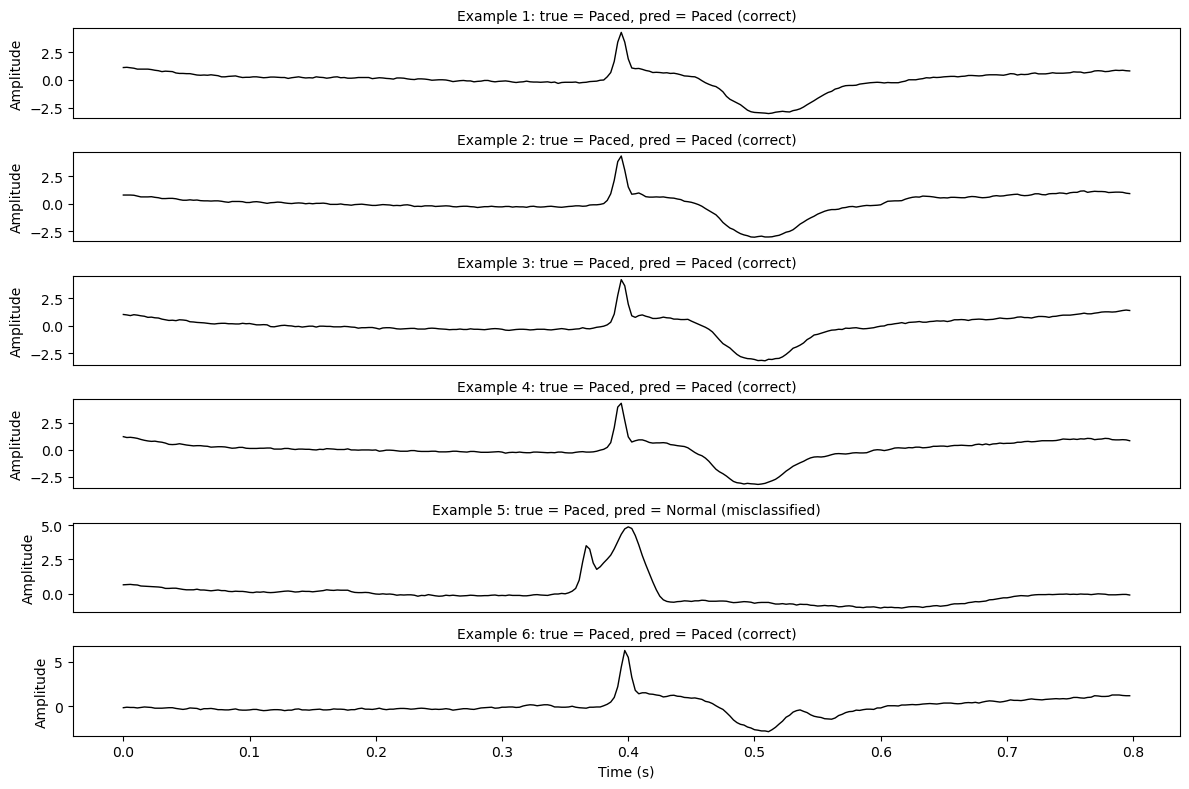

In [39]:
# Visualize example beats and predictions for the CNN model

run_name = 'simple_cnn_optimal_patient_wise'
ckpt_dir = demo_configs[run_name]
config = load_config(ckpt_dir)
model = load_best_model(ckpt_dir, config)
model.eval()

# Build a small test loader and get one batch
test_loader, test_dataset = create_test_loader_from_config(
    config,
    batch_size=32,
    num_workers=0,
)

signals_batch, labels_batch = next(iter(test_loader))
signals_batch = signals_batch.to(device)
labels_batch = labels_batch.to(device)

with torch.no_grad():
    logits = model(signals_batch)
    preds = logits.argmax(dim=1)

signals_np = signals_batch.cpu().numpy()  # [B, 1, T]
labels_np = labels_batch.cpu().numpy()
preds_np = preds.cpu().numpy()

n_to_show = min(6, signals_np.shape[0])
# Assume 360 Hz sampling; this matches how the data was prepared
fs = 360
T = signals_np.shape[2]

plt.figure(figsize=(12, 8))
for i in range(n_to_show):
    plt.subplot(n_to_show, 1, i + 1)
    t_axis = np.arange(T) / fs
    plt.plot(t_axis, signals_np[i, 0], color='black', linewidth=1)
    true_cls = CLASS_NAMES[labels_np[i]]
    pred_cls = CLASS_NAMES[preds_np[i]]
    correct = (labels_np[i] == preds_np[i])
    title = f"Example {i+1}: true = {true_cls}, pred = {pred_cls}"
    if correct:
        title += " (correct)"
    else:
        title += " (misclassified)"
    plt.title(title, fontsize=10)
    plt.ylabel("Amplitude")
    if i == n_to_show - 1:
        plt.xlabel("Time (s)")
    else:
        plt.xticks([])

plt.tight_layout()
plt.show()



Dataset Statistics:
  Total beats: 13687
  Records: 6

  Class distribution:
    Normal               (class 0):  10819 (79.05%)
    Supraventricular     (class 1):    159 ( 1.16%)
    Ventricular          (class 2):    620 ( 4.53%)
    Fusion               (class 3):     22 ( 0.16%)
    Paced                (class 4):   2044 (14.93%)
    Unknown              (class 5):     23 ( 0.17%)


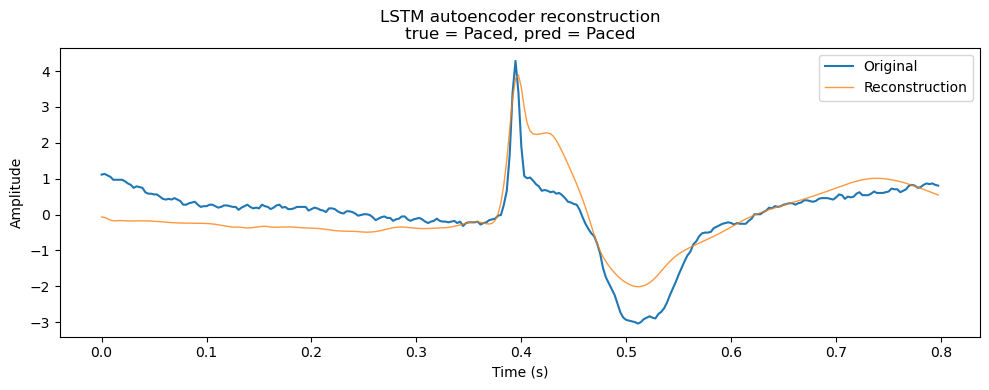

In [40]:
# Visualize original vs reconstructed beat for the LSTM autoencoder

run_name = 'lstm_curated_patient_wise'
ckpt_dir = demo_configs[run_name]
config = load_config(ckpt_dir)

lstm_model = load_best_model(ckpt_dir, config)
assert isinstance(lstm_model, LSTMAutoencoderClassifier)

lstm_model.eval()

# Build a small test loader and get one batch
test_loader, _ = create_test_loader_from_config(
    config,
    batch_size=16,
    num_workers=0,
)

signals_batch, labels_batch = next(iter(test_loader))
signals_batch = signals_batch.to(device)
labels_batch = labels_batch.to(device)

with torch.no_grad():
    recon_batch, logits = lstm_model(signals_batch)
    preds = logits.argmax(dim=1)

signals_np = signals_batch.cpu().numpy()      # [B, 1, T]
recon_np = recon_batch.cpu().numpy()          # [B, T, 1]
labels_np = labels_batch.cpu().numpy()
preds_np = preds.cpu().numpy()

idx = 0  # show the first example
orig = signals_np[idx, 0]        # [T]
recon = recon_np[idx, :, 0]      # [T]
fs = 360
T = orig.shape[0]

t_axis = np.arange(T) / fs

plt.figure(figsize=(10, 4))
plt.plot(t_axis, orig, label='Original', linewidth=1.5)
plt.plot(t_axis, recon, label='Reconstruction', linewidth=1.0, alpha=0.8)
true_cls = CLASS_NAMES[labels_np[idx]]
pred_cls = CLASS_NAMES[preds_np[idx]]
plt.title(f"LSTM autoencoder reconstruction\ntrue = {true_cls}, pred = {pred_cls}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()




## Summary

In this notebook we:

- **Loaded pre-trained CNN and LSTM autoencoder checkpoints** for multiple split strategies from `src/checkpoints/`.
- **Displayed full test-set metrics** (accuracy and loss) saved during the original training runs.
- **Ran fast live inference** on a deliberately **cherry-picked subset of the test data** to keep runtime and visualizations compact.
- **Visualized example ECG beats**, including correct and incorrect predictions and LSTM reconstructions.

This end-to-end demo is optimized to run in under one minute on a typical CPU machine. For **full training and evaluation on the complete datasets**, including all records and epochs, please refer to the detailed instructions in the project `README.md` and the training scripts in the `src/` directory.
